In [534]:
# Install version of keras which model was created on
!pip install keras==2.13.1

In [535]:
# Imports
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [536]:
# Load pre trained character model from drive
model = load_model("/content/drive/MyDrive/Training_data/my_model.keras")

In [537]:
# Set labels
characters = [str(i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)]

In [538]:
# Characters are all black, so we can filter out anything in a number plate with high intensity
def filter_characters(image, width, height):
  for row in range(height):
    for col in range(width):
      intensity = sum(image[row][col])
      if intensity > 150:
        image[row][col] = [255,255,255]

  return image

In [539]:
# Place boxes around all the characters and extract that part of the image
def extract_characters(image, width, height):
  boxes = []
  edges = cv2.Canny(image, 50, 150)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      if (w > (width / 12) and w < width / 2 and h > (height / 2)):
        boxes.append([x,y,w,h])
  sorted_boxes = sorted(boxes, key=lambda box: box[0])

  return sorted_boxes

In [540]:
# Predict characters with box placed around and string together a word
def predict_word(image, boxes):
  word = ""
  for [x,y,w,h] in boxes:
    roi = image[y:y+h, x:x+w]
    roi = cv2.resize(roi, (64, 64))
    roi = np.array(roi, dtype=np.float32)
    roi = np.expand_dims(roi, axis=0)
    roi = roi / 255
    y_pred = model.predict(roi, verbose=0)
    word += characters[np.argmax(y_pred)]

  return word

In [541]:
# Main function to read a numberplate image
def read_numberplate(filename):
  word = ""
  real_image = cv2.imread(filename)
  image = cv2.imread(filename, cv2.COLOR_BGR2GRAY)
  height, width, _ = image.shape
  image = filter_characters(image, width, height)
  sorted_boxes = extract_characters(image, width, height)

  return predict_word(image, sorted_boxes), real_image

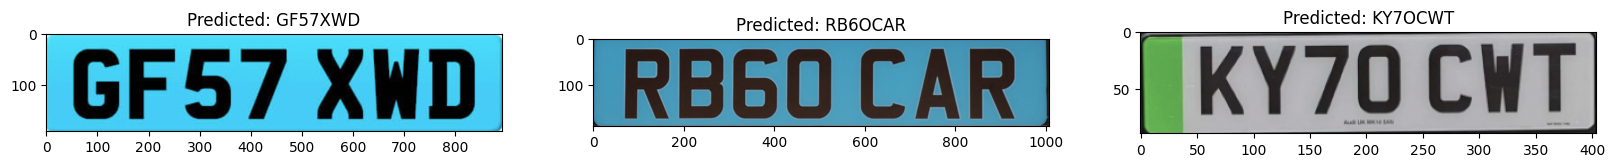

In [542]:
# Display sample plates and predict
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize =(20,10))
for i in range(1,4):
  word, image = read_numberplate(f"/content/drive/MyDrive/Training_data/numberplate_test{i}.png")
  axes[i-1].imshow(image)
  axes[i-1].set_title(f"Predicted: {word}")
plt.show()